# Data Processing, EDA, Regression and Classifiction
### Proccess backfilled data, look into variable relationships, use predictive regression, and classify snow/rain on snow events
### Written by: Hailey Sparks

In [1]:
pip install metloom # uncomment to install metloom

  Using cached metloom-0.6.3-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached geopandas-0.14.4-py3-none-any.whl.metadata (1.5 kB)
  Using cached zeep-4.3.1-py3-none-any.whl.metadata (4.3 kB)
  Using cached isodate-0.7.2-py3-none-any.whl.metadata (11 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached requests_file-2.1.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached metloom-0.6.3-py2.py3-none-any.whl (56 kB)
Using cached geopandas-0.14.4-py3-none-any.whl (1.1 MB)
Using cached zeep-4.3.1-py3-none-any.whl (101 kB)
Using cached isodate-0.7.2-py3-none-any.whl (22 kB)
Using cached requests_file-2.1.0-py2.py3-none-any.whl (4.2 kB)
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalled geopandas-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packa

In [2]:
pip install pint_xarray # uncomment to install pint_xarray

  Using cached pint_xarray-0.4-py3-none-any.whl.metadata (3.2 kB)
  Using cached Pint-0.24.4-py3-none-any.whl.metadata (8.5 kB)
  Using cached flexcache-0.3-py3-none-any.whl.metadata (7.0 kB)
  Using cached flexparser-0.4-py3-none-any.whl.metadata (18 kB)
Using cached pint_xarray-0.4-py3-none-any.whl (32 kB)
Using cached Pint-0.24.4-py3-none-any.whl (302 kB)
Using cached flexcache-0.3-py3-none-any.whl (13 kB)
Using cached flexparser-0.4-py3-none-any.whl (27 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# import needed packages

import numpy as np
from datetime import datetime
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import xarray as xr
import contextily as ctx
import shapely
import pint_xarray
from metloom.pointdata import SnotelPointData, USGSPointData
import seaborn as sns

In [4]:
# places where two snotels disagree 
# are there times when one site predicts snow and another predicts rain on snow at one time 
# see what temperature these things happen at 
# visual of what rain on snow looks like, what characterizes it 
# plot: one axis has discharge, another has temp

In [5]:
# we will look at january through april 
# predict discharge based on the snotel data
# spike in discharge means rain on snow, we will have 2 classes, so binary classification
# final goal: get a decision tree to predict discharge spikes based on snotel data 
# truth rain from snotel, infer it from discharge


# SWE: snow water equivalent: determines how much water the snowpack contains

# Data Proccessing 
## Downloading, cleaning, and re-formatting

In [6]:
# Here we include the function needed to fill nan values
# null values will be replaced with the mean of the row before and after it

def fill_null(df):
    df = df.copy()
    df = df.reset_index()
    
    for col in df.columns:
        print("cleaning ", col)
        null_indices = df[df[col].isnull()].index
        for i in null_indices:
            before = df.loc[i-1, col] if i > 0 else np.nan
            after = df.loc[i+1, col] if i < len(df) - 1 else np.nan

            #Handle cases where either before or after is also NaN
            valid_values = [x for x in [before, after] if pd.notna(x)]
            if valid_values:
              df.loc[i, col] = np.mean(valid_values)
            #If both before and after are NaN, leave the NaN as is
            
    return df

## Load in the backfilled data from backfill.ipynb

In [7]:
# load in the data from 1980-2024
# The user warning can be ignored

snotel_hourly = xr.open_dataset('../../data/snotel/snotel_hourly_backfill_1980_2024.zarr')
usgs_hourly = xr.open_dataset('../../data/stream/usgs_instantaneous_backfill_1980_2024.zarr')

/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/Users/jesse/pro

In [8]:
# preview of snotel data
snotel_hourly

<xarray.Dataset> Size: 82MB
Dimensions:                    (date: 1134647, site: 2)
Coordinates:
    site_name                  (site) object 16B ...
  * date                       (date) datetime64[ns] 9MB 1989-10-01T07:15:00 ...
    elevation_ft               (site) float64 16B ...
    lat                        (site) float64 16B ...
    lon                        (site) float64 16B ...
  * site                       (site) object 16B '817:WA:SNTL' '990:WA:SNTL'
Data variables:
    ACCUMULATED PRECIPITATION  (date, site) float64 18MB ...
    SNOWDEPTH                  (date, site) float64 18MB ...
    SWE                        (date, site) float64 18MB ...
    AIR TEMP                   (date, site) float64 18MB ...
Attributes:
    Description:  Snotel Data
    Date Range:   1980-2024
    Sites:        Thunder Basin, Beaver Creek
    Frequency:    Hourly

In [9]:
# preview of usgs data
usgs_hourly

<xarray.Dataset> Size: 27MB
Dimensions:       (site: 2, date: 1134647)
Coordinates:
    elevation_ft  (site) float64 16B ...
    site_name     (site) object 16B ...
    lon           (site) float64 16B ...
  * site          (site) object 16B '12172000' '12175500'
    lat           (site) float64 16B ...
  * date          (date) datetime64[ns] 9MB 1989-10-01T07:15:00 ... 2024-01-0...
Data variables:
    DISCHARGE     (date, site) float64 18MB ...
Attributes:
    Description:  Streamflow Data
    Date Range:   1980-2024
    Sites:        Thunder Creek, Beaver Creek
    Frequency:    15-Min

In [10]:
# only keep years 2019-2024, and months January-April

snotel_month_filtered = snotel_hourly.sel(date=snotel_hourly.date.dt.month.isin([1,2,3])).sel(date=slice('2019-01-01', '2024-04-01'))
discharge_month_filtered = usgs_hourly.sel(date=usgs_hourly.date.dt.month.isin([1,2,3])).sel(date=slice('2019-01-01', '2024-04-01'))

In [11]:
discharge_month_filtered

<xarray.Dataset> Size: 1MB
Dimensions:       (site: 2, date: 59060)
Coordinates:
    elevation_ft  (site) float64 16B ...
    site_name     (site) object 16B ...
    lon           (site) float64 16B ...
  * site          (site) object 16B '12172000' '12175500'
    lat           (site) float64 16B ...
  * date          (date) datetime64[ns] 472kB 2019-01-01 ... 2024-01-02T07:45:00
Data variables:
    DISCHARGE     (date, site) float64 945kB ...
Attributes:
    Description:  Streamflow Data
    Date Range:   1980-2024
    Sites:        Thunder Creek, Beaver Creek
    Frequency:    15-Min

In [12]:
# line up usgs discharge with their correct sites 

discharge = []
discharge_by_site = discharge_month_filtered.DISCHARGE.values
dishcarge_thunder = discharge_by_site[:,0]
dishcarge_beaver = discharge_by_site[:,1]
for i in range(0,len(dishcarge_thunder)):
    discharge.append(dishcarge_thunder[i])
    discharge.append(dishcarge_beaver[i])

In [13]:
# add discharge to the SNOTEL data 
snotel_hourly_gdf = snotel_month_filtered.to_dataframe().reset_index()
snotel_hourly_numeric = snotel_hourly_gdf.copy()
snotel_hourly_numeric['DISCHARGE'] = discharge

# group by site while keeping the data in chronological order 
grouped_by_site = snotel_hourly_numeric.sort_values(['site','date'],ascending=True).groupby('site')
grouped_by_site =grouped_by_site.apply(pd.DataFrame, include_groups=False)
grouped_by_site

date  ACCUMULATED PRECIPITATION  \
site                                                                
817:WA:SNTL 0      2019-01-01 00:00:00                       31.2   
            2      2019-01-01 00:05:00                       31.2   
            4      2019-01-01 00:10:00                       31.2   
            6      2019-01-01 00:15:00                       31.2   
            8      2019-01-01 00:20:00                       31.2   
...                                ...                        ...   
990:WA:SNTL 118111 2024-01-02 06:45:00                        NaN   
            118113 2024-01-02 07:00:00                        NaN   
            118115 2024-01-02 07:15:00                        NaN   
            118117 2024-01-02 07:30:00                        NaN   
            118119 2024-01-02 07:45:00                        NaN   

                        site_name  SNOWDEPTH  elevation_ft   SWE     lat  \
site                                                                       
817:WA:SNTL 0        Beaver Creek       50.0        4310.0  15.2  48.528   
            2        Beaver Creek       49.0        4310.0  15.2  48.528   
            4        Beaver Creek       49.0        4310.0  15.2  48.528   
            6        Beaver Creek       49.0        4310.0  15.2  48.528   
            8        Beaver Creek       49.0        4310.0  15.2  48.528   
...                           ...        ...           ...   ...     ...   
990:WA:SNTL 118111  Thunder Basin        NaN        3630.0   NaN  48.879   
            118113  Thunder Basin        NaN        3630.0   NaN  48.879   
            118115  Thunder Basin        NaN        3630.0   NaN  48.879   
            118117  Thunder Basin        NaN        3630.0   NaN  48.879   
            118119  Thunder Basin        NaN        3630.0   NaN  48.879   

                    AIR TEMP      lon  DISCHARGE  
site                                              
817:WA:SNTL 0          12.56 -120.990      247.0  
            2          10.94 -120.990      249.0  
            4          10.94 -120.990      249.0  
            6          10.94 -120.990      249.0  
            8          10.94 -120.990      247.0  
...                      ...      ...        ...  
990:WA:SNTL 118111       NaN -121.256      208.0  
            118113       NaN -121.256      210.0  
            118115       NaN -121.256      210.0  
            118117       NaN -121.256      208.0  
            118119       NaN -121.256      208.0  

[118120 rows x 10 columns]

In [75]:
# only keep numeric data 

data_numeric = grouped_by_site.filter(items=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'])
data_numeric

ACCUMULATED PRECIPITATION   SWE  AIR TEMP  DISCHARGE
site                                                                    
817:WA:SNTL 0                            31.2  15.2     12.56      247.0
            2                            31.2  15.2     10.94      249.0
            4                            31.2  15.2     10.94      249.0
            6                            31.2  15.2     10.94      249.0
            8                            31.2  15.2     10.94      247.0
...                                       ...   ...       ...        ...
990:WA:SNTL 118111                        NaN   NaN       NaN      208.0
            118113                        NaN   NaN       NaN      210.0
            118115                        NaN   NaN       NaN      210.0
            118117                        NaN   NaN       NaN      208.0
            118119                        NaN   NaN       NaN      208.0

[118120 rows x 4 columns]

In [15]:
# handle null values in the data
hourly_cleaned = fill_null(data_numeric)

# get rid of the level_1 column that was added 
hourly_cleaned = hourly_cleaned.drop("level_1", axis =1)
hourly_cleaned

cleaning  site
cleaning  level_1
cleaning  ACCUMULATED PRECIPITATION
cleaning  SWE
cleaning  AIR TEMP
cleaning  DISCHARGE


,site,ACCUMULATED PRECIPITATION,SWE,AIR TEMP,DISCHARGE
0,817:WA:SNTL,31.2,15.2,12.56,247.0
1,817:WA:SNTL,31.2,15.2,10.94,249.0
2,817:WA:SNTL,31.2,15.2,10.94,249.0
3,817:WA:SNTL,31.2,15.2,10.94,249.0
4,817:WA:SNTL,31.2,15.2,10.94,247.0
...,...,...,...,...,...
118115,990:WA:SNTL,24.1,6.3,30.20,208.0
118116,990:WA:SNTL,24.1,6.3,30.20,210.0
118117,990:WA:SNTL,24.1,6.3,30.20,210.0
118118,990:WA:SNTL,24.1,6.3,30.20,208.0


# Let's Check out the relationship among variables

## Correlation Matrix

<Axes: >

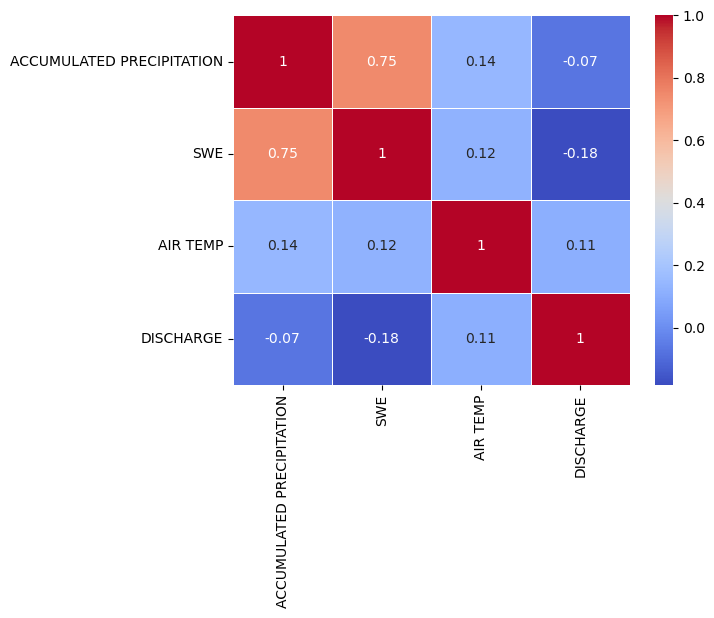

In [16]:
data_corr_matrix = hourly_cleaned.drop(['site'], axis=1).corr()
sns.heatmap(data_corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)

### Relationship between Air Temp (F) and Discharge
#### We expect to see that there are higher discharge values at higher temperatures 

Text(0, 0.5, 'Discharge (cubic feet/sec)')

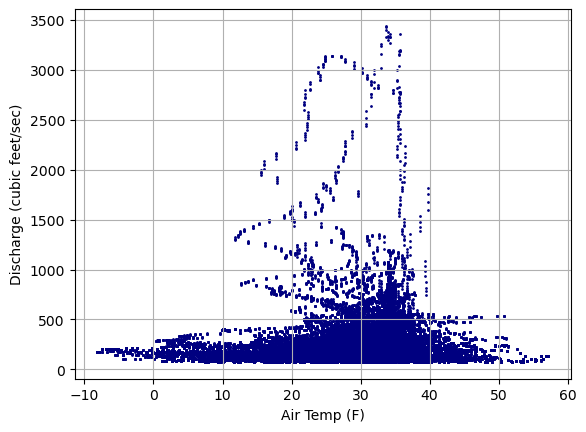

In [17]:
plt.grid()
plt.scatter(hourly_cleaned['AIR TEMP'], hourly_cleaned['DISCHARGE'], s=1, c='navy')
plt.xlabel("Air Temp (F)")
plt.ylabel("Discharge (cubic feet/sec)")

### Classification
#### Fit a model based on air temp, SWE, and snow_depth to predict discharge 

In [18]:
# set grounds truths

# Snow or Rain on Snow: binary classification
# 0: Snow 
# 1: Rain on Snow 

### We will use a basic rolling mean classification

In [19]:
# calculates the rolling means and standard deviation  

def rolling_stats(data,var):
    # Calculate the rolling median and standard deviation
    rolling_median = data[var].rolling(window=24, center=True, min_periods=1).median()
    rolling_std = data[var].rolling(window=24, center=True, min_periods=1).std()

    return [rolling_median, rolling_std]

In [20]:
def assign_labels(data, var): #air_temp = False):
    mu = rolling_stats(data,var)[0]
    sigma = rolling_stats(data,var)[1]

    truths = []
    mask = data[var] > mu+(sigma/2)
    truths = mask

    return truths

In [21]:
ground_truths = assign_labels(hourly_cleaned, 'DISCHARGE') #air_temp = False)

In [22]:
hourly_cleaned['ROS'] = ground_truths
hourly_cleaned['date'] = grouped_by_site['date'].values

# now regroup the cleaned and classified numeric data with the sites 
events_by_site = hourly_cleaned.groupby('site').resample('D', on='date').max().drop(columns=['site']).dropna(how='any')
# save the classified data
events_by_site.to_csv('../../data/classified_data/ros_events_by_site.csv')

# Prediction and Decision Tree Regression 
### Predict float discharge values based on the snotel data

In [54]:
# import packages needed for regression
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree

In [24]:
# convert the data to matrix form for model building 
X_data = hourly_cleaned.drop(['site', 'DISCHARGE', 'date', 'ROS'], axis =1)
X_data = X_data.to_numpy()

In [25]:
X_data

array([[31.2 , 15.2 , 12.56],
       [31.2 , 15.2 , 10.94],
       [31.2 , 15.2 , 10.94],
       ...,
       [24.1 ,  6.3 , 30.2 ],
       [24.1 ,  6.3 , 30.2 ],
       [24.1 ,  6.3 , 30.2 ]], shape=(118120, 3))

In [26]:
# Function that will run the Decision Tree Regression using the predictor X matrix 
# and target y values. Must specify the max depth of the tree.

def run_regr(X,y, max_depth):
    # split the data into train and test sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(
    X_data, y, test_size=0.20)

    # build the regressor
    clfr = tree.DecisionTreeRegressor(max_depth = max_depth)

    # fit the model 
    clfr.fit(X_train, y_train)

    # score the model
    score = clfr.score(X_test, y_test)
    print(f"Test Score: {score:.4f}")
    y_pred = clfr.predict(X_test)

    # investigate MSE
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")

    return score 

In [33]:
# test the regressor for different tree depths: 1-20

accs = []
for i in range(1,21):
    accs.append(run_regr(X_data,hourly_cleaned['DISCHARGE'], i))

Test Score: 0.1153
Mean Squared Error: 28522.4742
Test Score: 0.1439
Mean Squared Error: 29602.8853
Test Score: 0.2143
Mean Squared Error: 25583.1729
Test Score: 0.2968
Mean Squared Error: 22502.6397
Test Score: 0.4717
Mean Squared Error: 18191.2654
Test Score: 0.6531
Mean Squared Error: 11236.7098
Test Score: 0.7571
Mean Squared Error: 7616.5362
Test Score: 0.8618
Mean Squared Error: 4896.6459
Test Score: 0.8932
Mean Squared Error: 3591.7637
Test Score: 0.8952
Mean Squared Error: 3440.1844
Test Score: 0.9546
Mean Squared Error: 1444.9176
Test Score: 0.9504
Mean Squared Error: 1556.7542
Test Score: 0.9841
Mean Squared Error: 606.0393
Test Score: 0.9596
Mean Squared Error: 1413.4834
Test Score: 0.9804
Mean Squared Error: 622.4627
Test Score: 0.9947
Mean Squared Error: 172.8980
Test Score: 0.9735
Mean Squared Error: 927.1376
Test Score: 0.9955
Mean Squared Error: 148.3437
Test Score: 0.9946
Mean Squared Error: 189.9226
Test Score: 0.9964
Mean Squared Error: 124.6890


Text(0, 0.5, 'Test Accuracy')

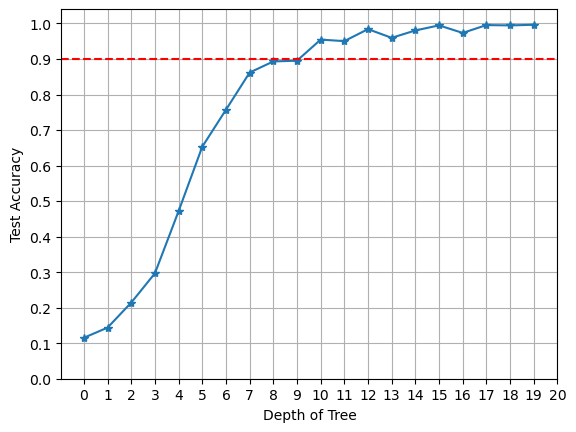

In [34]:
# Plot the testaccuracy for different tree depths 
# Notice the upward trend 

plt.plot(accs, '-*')
plt.grid()
custom_ticks = [i for i in range(0,21)]
custom_y = [0,0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9,1]
plt.xticks(custom_ticks)
plt.yticks(custom_y)
plt.xlabel("Depth of Tree")
plt.axhline(0.9,linestyle = '--', c='red')
plt.ylabel("Test Accuracy")

In [35]:
# we will visualize a model with max depth of 10, as this can get us to over 90% testing accuracy

X = X_data
y = hourly_cleaned['DISCHARGE']

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y, test_size=0.20)

# save the model for visualization
clfr = tree.DecisionTreeRegressor(max_depth = 10)

# fit the model and score it 
clfr.fit(X_train, y_train)
test_score = clfr.score(X_test, y_test)
print(f"Test Score: {(test_score*100):.4f} %")

# predict test discharge values
y_pred = clfr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Test Score: 94.4908 %
Mean Squared Error: 1850.7763


In [36]:
# check the depth of the tree 
clfr.get_depth()

10

### Uncomment the below cell to visualize the entire tree
### Note that this will only be readable for smaller trees

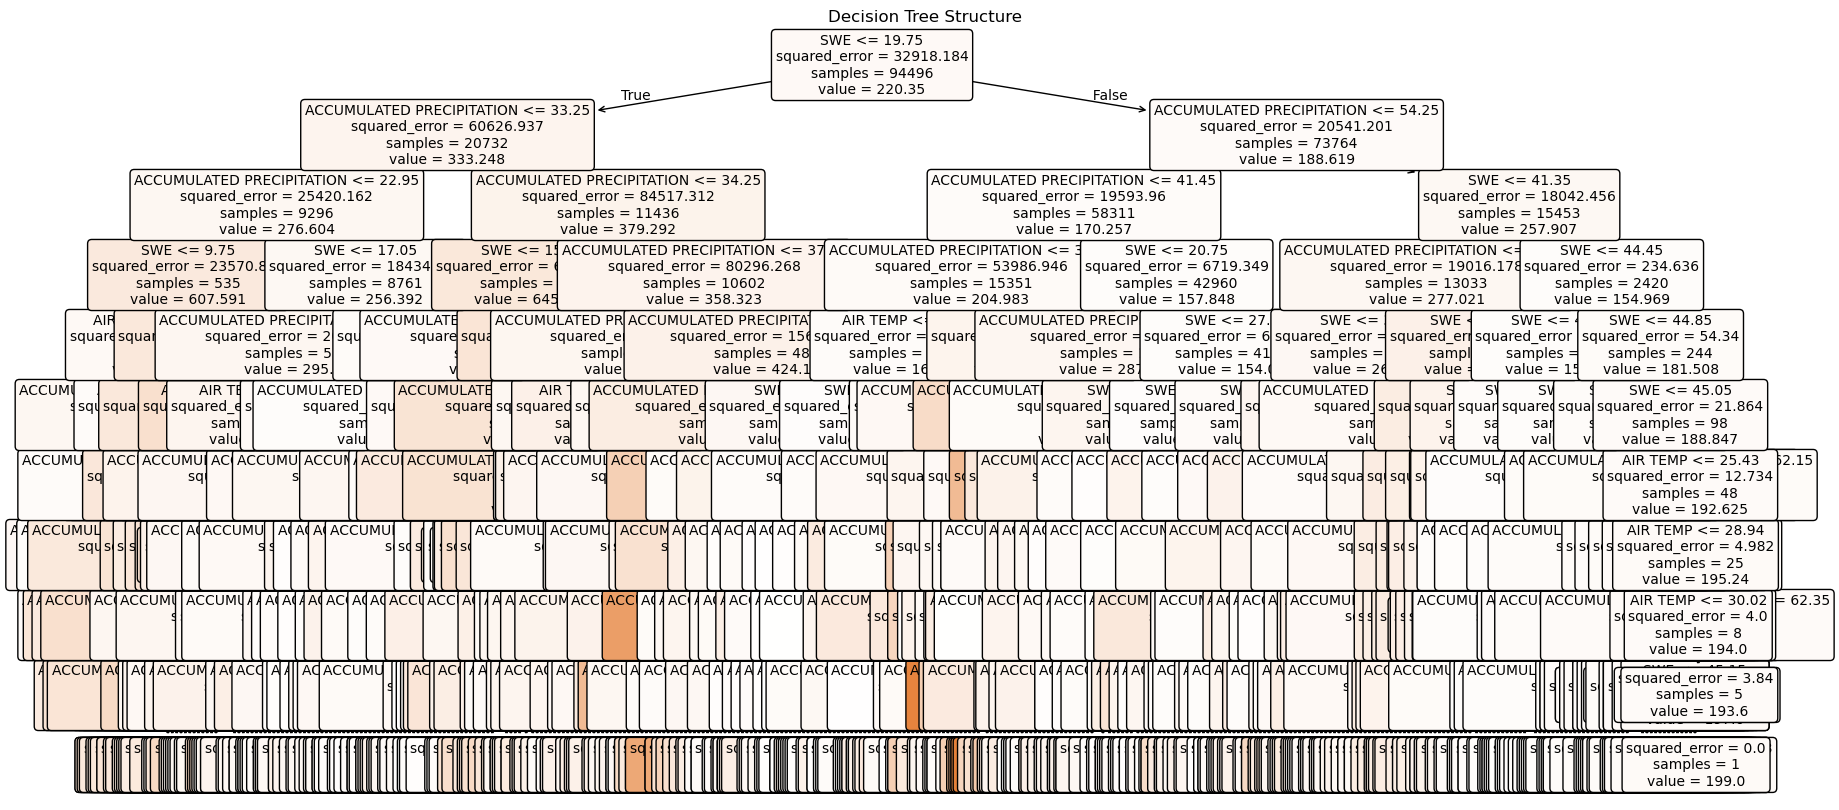

In [97]:
#from sklearn.tree import plot_tree

# Visualizing decision tree
#plt.figure(figsize=(20, 10))
#plot_tree(
#   clfr,
#   feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP'],
#   filled=True,
#   rounded=True,
#    fontsize=10
#)
#plt.title("Decision Tree Structure")
#plt.show()


## Visual Comparison of Results

In [37]:
# predict all discharge values for the entire time series to compare with the true values
y_predicted = clfr.predict(X)

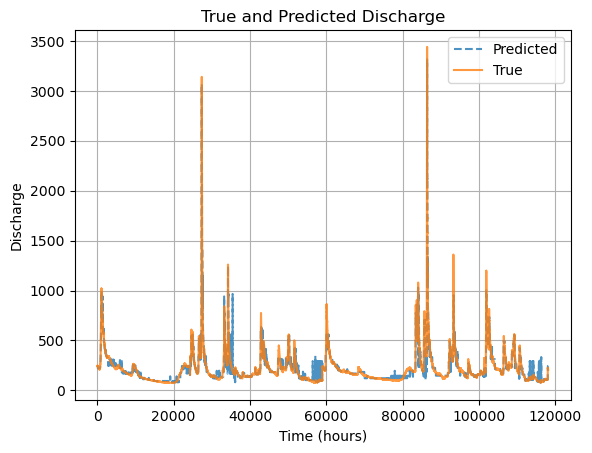

In [38]:
# plot the predicted discharge values with the true values

plt.title("True and Predicted Discharge")
#plt.plot(y_pred)
plt.plot(y_predicted, '--',label = 'Predicted', alpha = 0.8)
plt.plot(y, label = 'True', alpha = 0.8)
plt.legend()
plt.ylabel("Discharge")
plt.xlabel("Time (hours)")
plt.grid()

## Decision Tree Classification

#### Predicts integer values 0 (snow) or 1 (rain on snow)

In [41]:
# Reminder of the data structure
data_numeric

ACCUMULATED PRECIPITATION   SWE  AIR TEMP  DISCHARGE
site                                                                    
817:WA:SNTL 0                            31.2  15.2     12.56      247.0
            2                            31.2  15.2     10.94      249.0
            4                            31.2  15.2     10.94      249.0
            6                            31.2  15.2     10.94      249.0
            8                            31.2  15.2     10.94      247.0
...                                       ...   ...       ...        ...
990:WA:SNTL 118111                        NaN   NaN       NaN      208.0
            118113                        NaN   NaN       NaN      210.0
            118115                        NaN   NaN       NaN      210.0
            118117                        NaN   NaN       NaN      208.0
            118119                        NaN   NaN       NaN      208.0

[118120 rows x 4 columns]

In [93]:
# use sklearns decision tree

from sklearn import tree
X_data_class = data_numeric.to_numpy() 


X_train, X_test, y_train, y_test = train_test_split(
    X_data_class, ground_truths.to_numpy().tolist(), test_size=0.20)

clf = tree.DecisionTreeClassifier(max_depth = 10)

# y_train_labels will be a vector of 0s and 1s from the ground_truths 
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [94]:
# score the model
score = clf.score(X_test, y_test)
print(f"Test Score: {score:.4f}")
y_pred = clf.predict(X_test)

# investigate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Test Score: 0.9091
Mean Squared Error: 0.0909


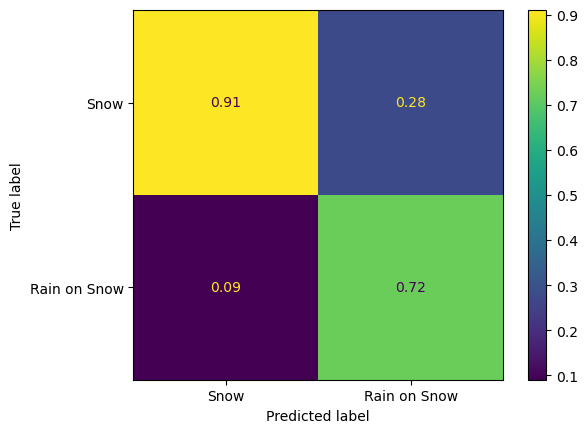

In [95]:
# add confusion matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_true = y_test
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_true, y_pred, normalize = 'pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["Snow", "Rain on Snow"])
disp.plot()
plt.show()


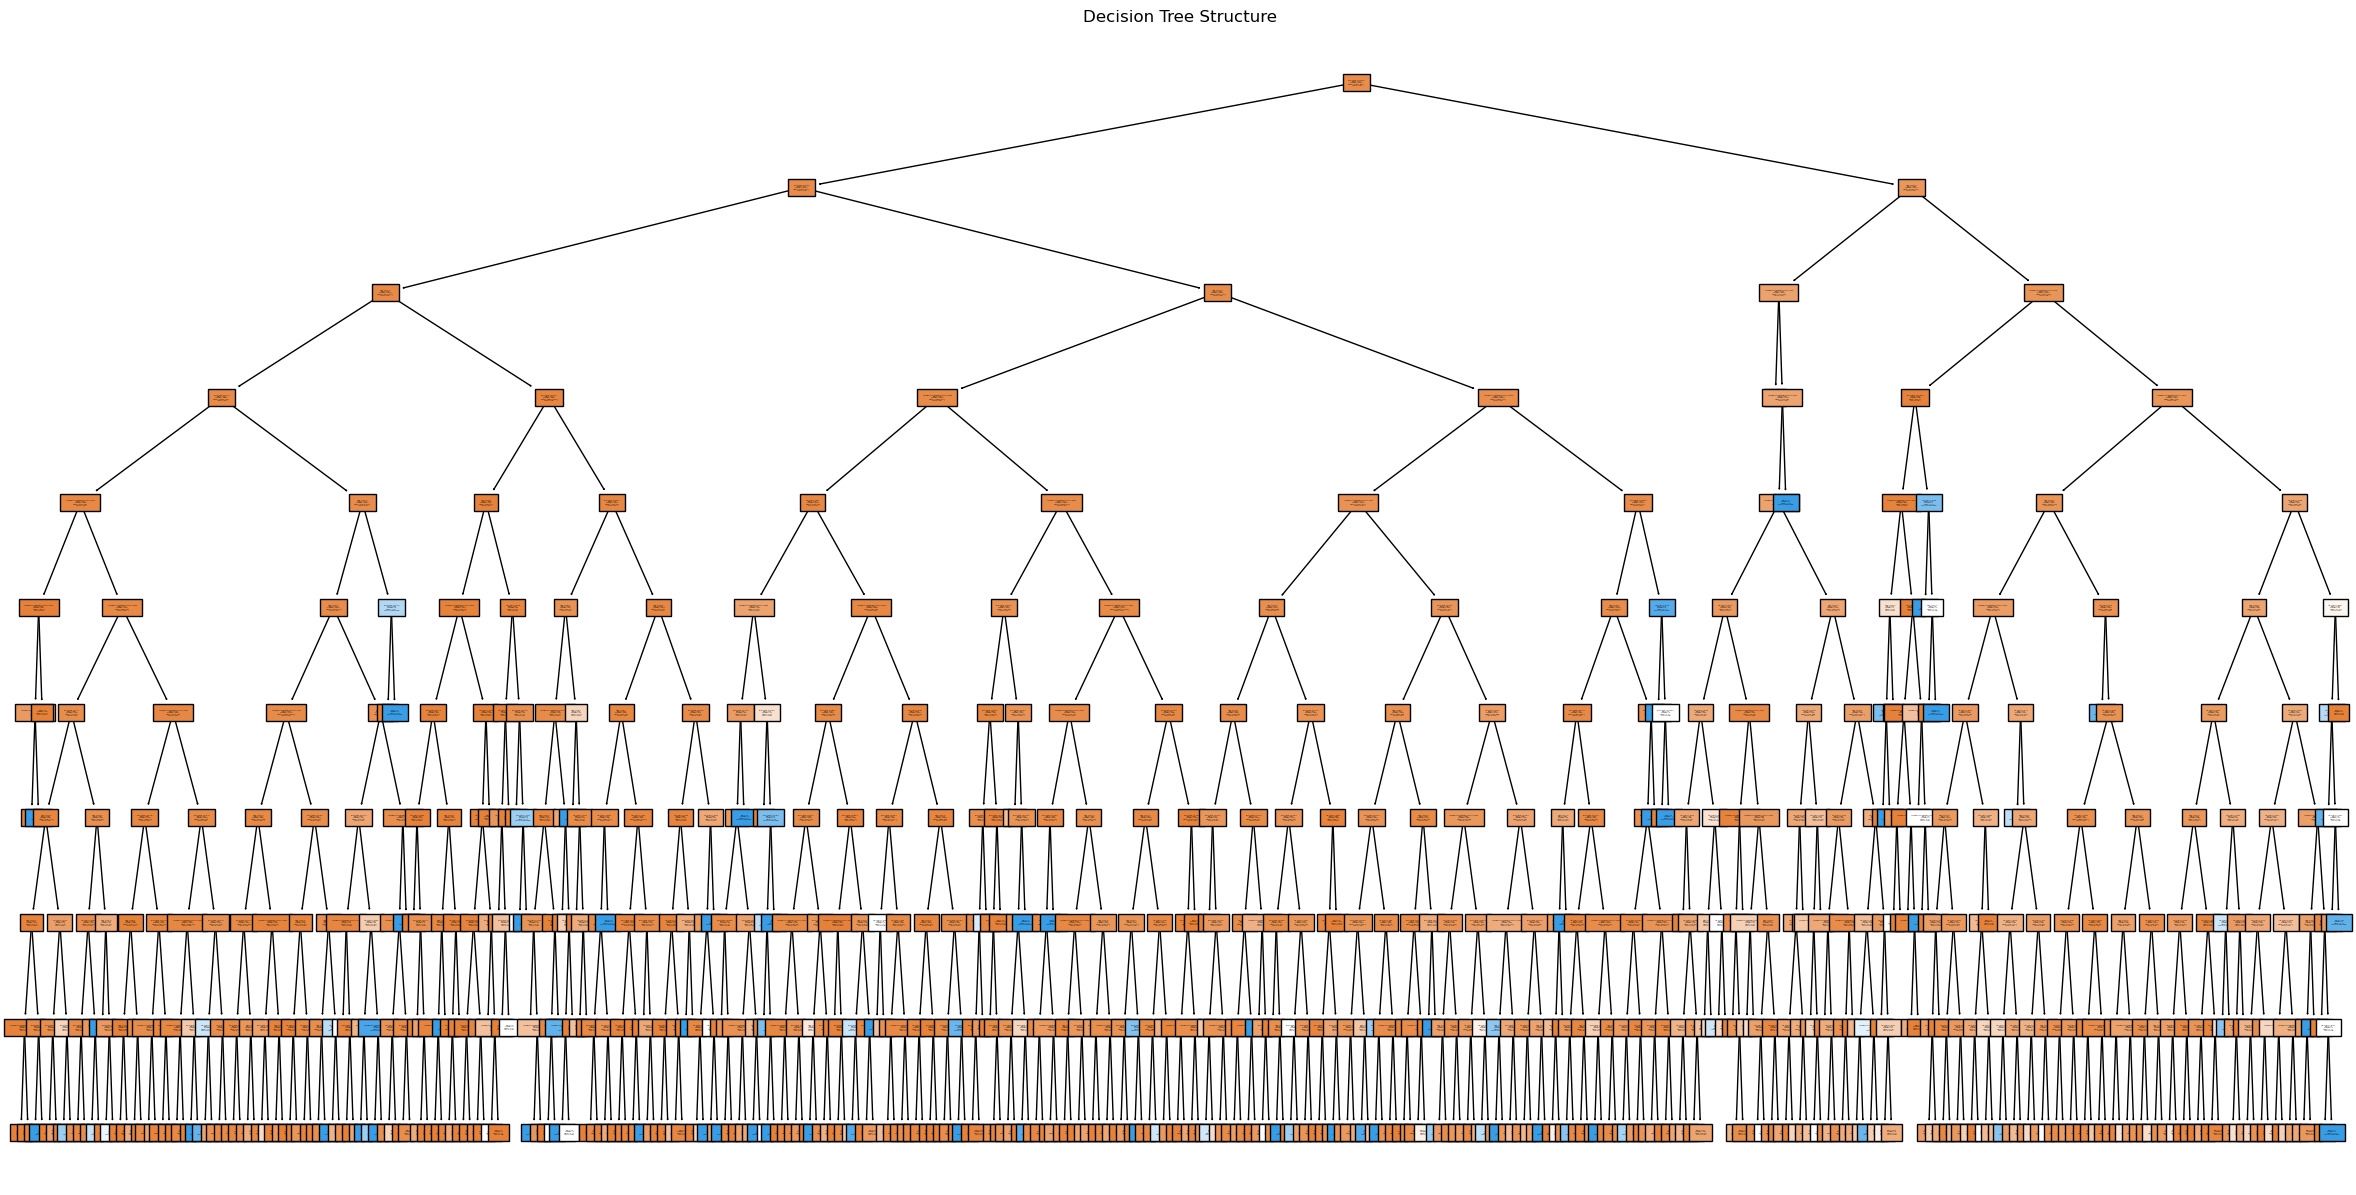

In [83]:
# This is the entire tree with depth 10... not very helpful visually 

plt.figure(figsize=(30, 15))

plot_tree(
    clf,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'],
    filled=True,
    class_names=['Snow', 'Rain on Snow'],
    #rounded=True,
    fontsize=1
)
plt.title("Decision Tree Structure")
plt.show()

## Tree Pruning

In [59]:
# Run the classification algrithm for different tree depths

def run_class(X,y, max_depth):
    X_train, X_test, y_train, y_test = train_test_split(
    X_data, y, test_size=0.20)
 
    clf = tree.DecisionTreeClassifier(max_depth = max_depth)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f"Test Score: {score:.4f}")
    y_pred = clf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")

    return score 

In [60]:
accs = []
for i in range(1,21):
    accs.append(run_class(X_data_class, ground_truths.to_numpy().tolist(), i))

Test Score: 0.9090
Mean Squared Error: 0.0910
Test Score: 0.9087
Mean Squared Error: 0.0913
Test Score: 0.9120
Mean Squared Error: 0.0880
Test Score: 0.9090
Mean Squared Error: 0.0910
Test Score: 0.9109
Mean Squared Error: 0.0891
Test Score: 0.9090
Mean Squared Error: 0.0910
Test Score: 0.9088
Mean Squared Error: 0.0912
Test Score: 0.9077
Mean Squared Error: 0.0923
Test Score: 0.9108
Mean Squared Error: 0.0892
Test Score: 0.9098
Mean Squared Error: 0.0902
Test Score: 0.9075
Mean Squared Error: 0.0925
Test Score: 0.9062
Mean Squared Error: 0.0938
Test Score: 0.9083
Mean Squared Error: 0.0917
Test Score: 0.9057
Mean Squared Error: 0.0943
Test Score: 0.9109
Mean Squared Error: 0.0891
Test Score: 0.9052
Mean Squared Error: 0.0948
Test Score: 0.9085
Mean Squared Error: 0.0915
Test Score: 0.9069
Mean Squared Error: 0.0931
Test Score: 0.9064
Mean Squared Error: 0.0936
Test Score: 0.9072
Mean Squared Error: 0.0928


Text(0, 0.5, 'Test Accuracy')

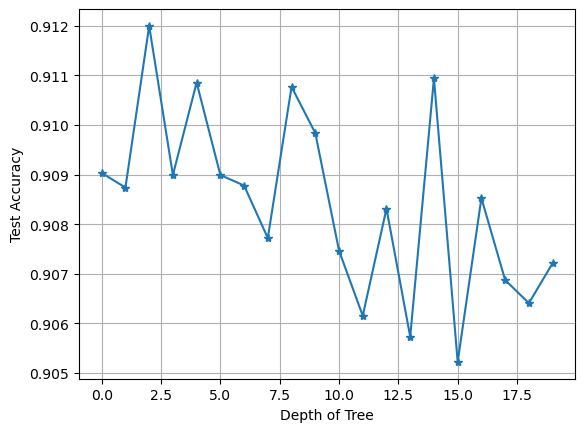

In [78]:
plt.plot(accs, '-*')
plt.grid()
plt.xlabel("Depth of Tree")
plt.ylabel("Test Accuracy")

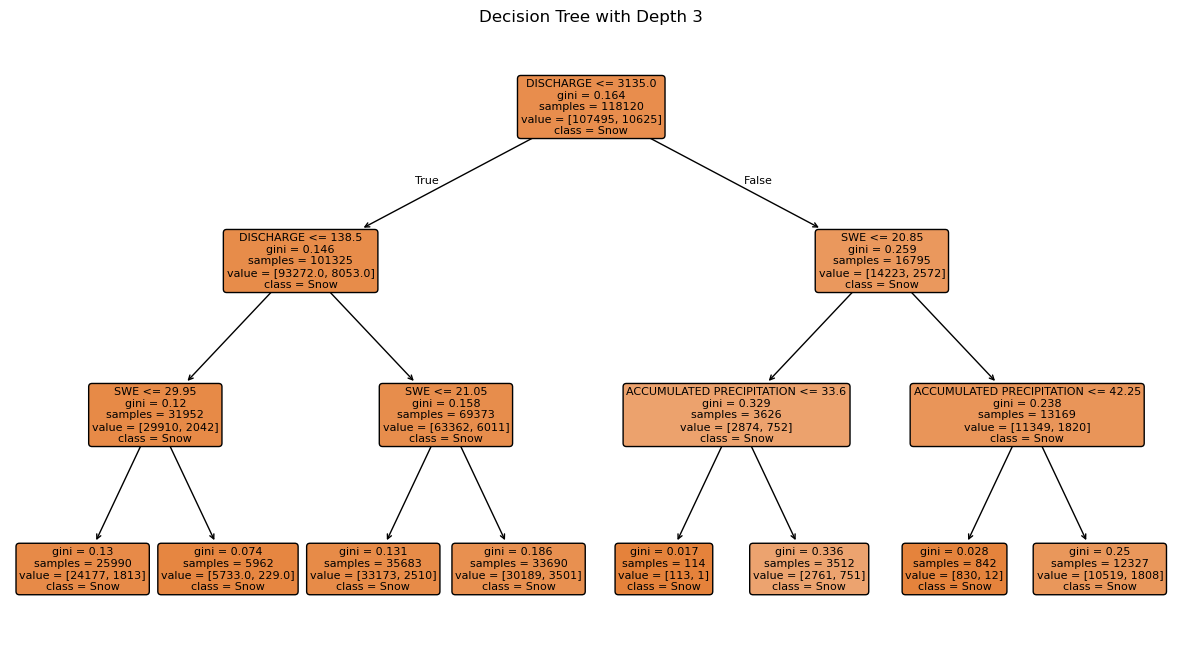

In [76]:
# Here is a smaller tree
# Note that no rain on snow regions are present

clf = tree.DecisionTreeClassifier(max_depth = 3)
clf.fit(X_data_class, ground_truths.to_numpy().tolist())
plt.figure(figsize=(15, 8))
plot_tree(
    clf,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'],
    filled=True,
    rounded=True,
    class_names=['Snow', 'Rain on Snow'],
    fontsize=8
)
plt.title("Decision Tree with Depth 3")
plt.show()

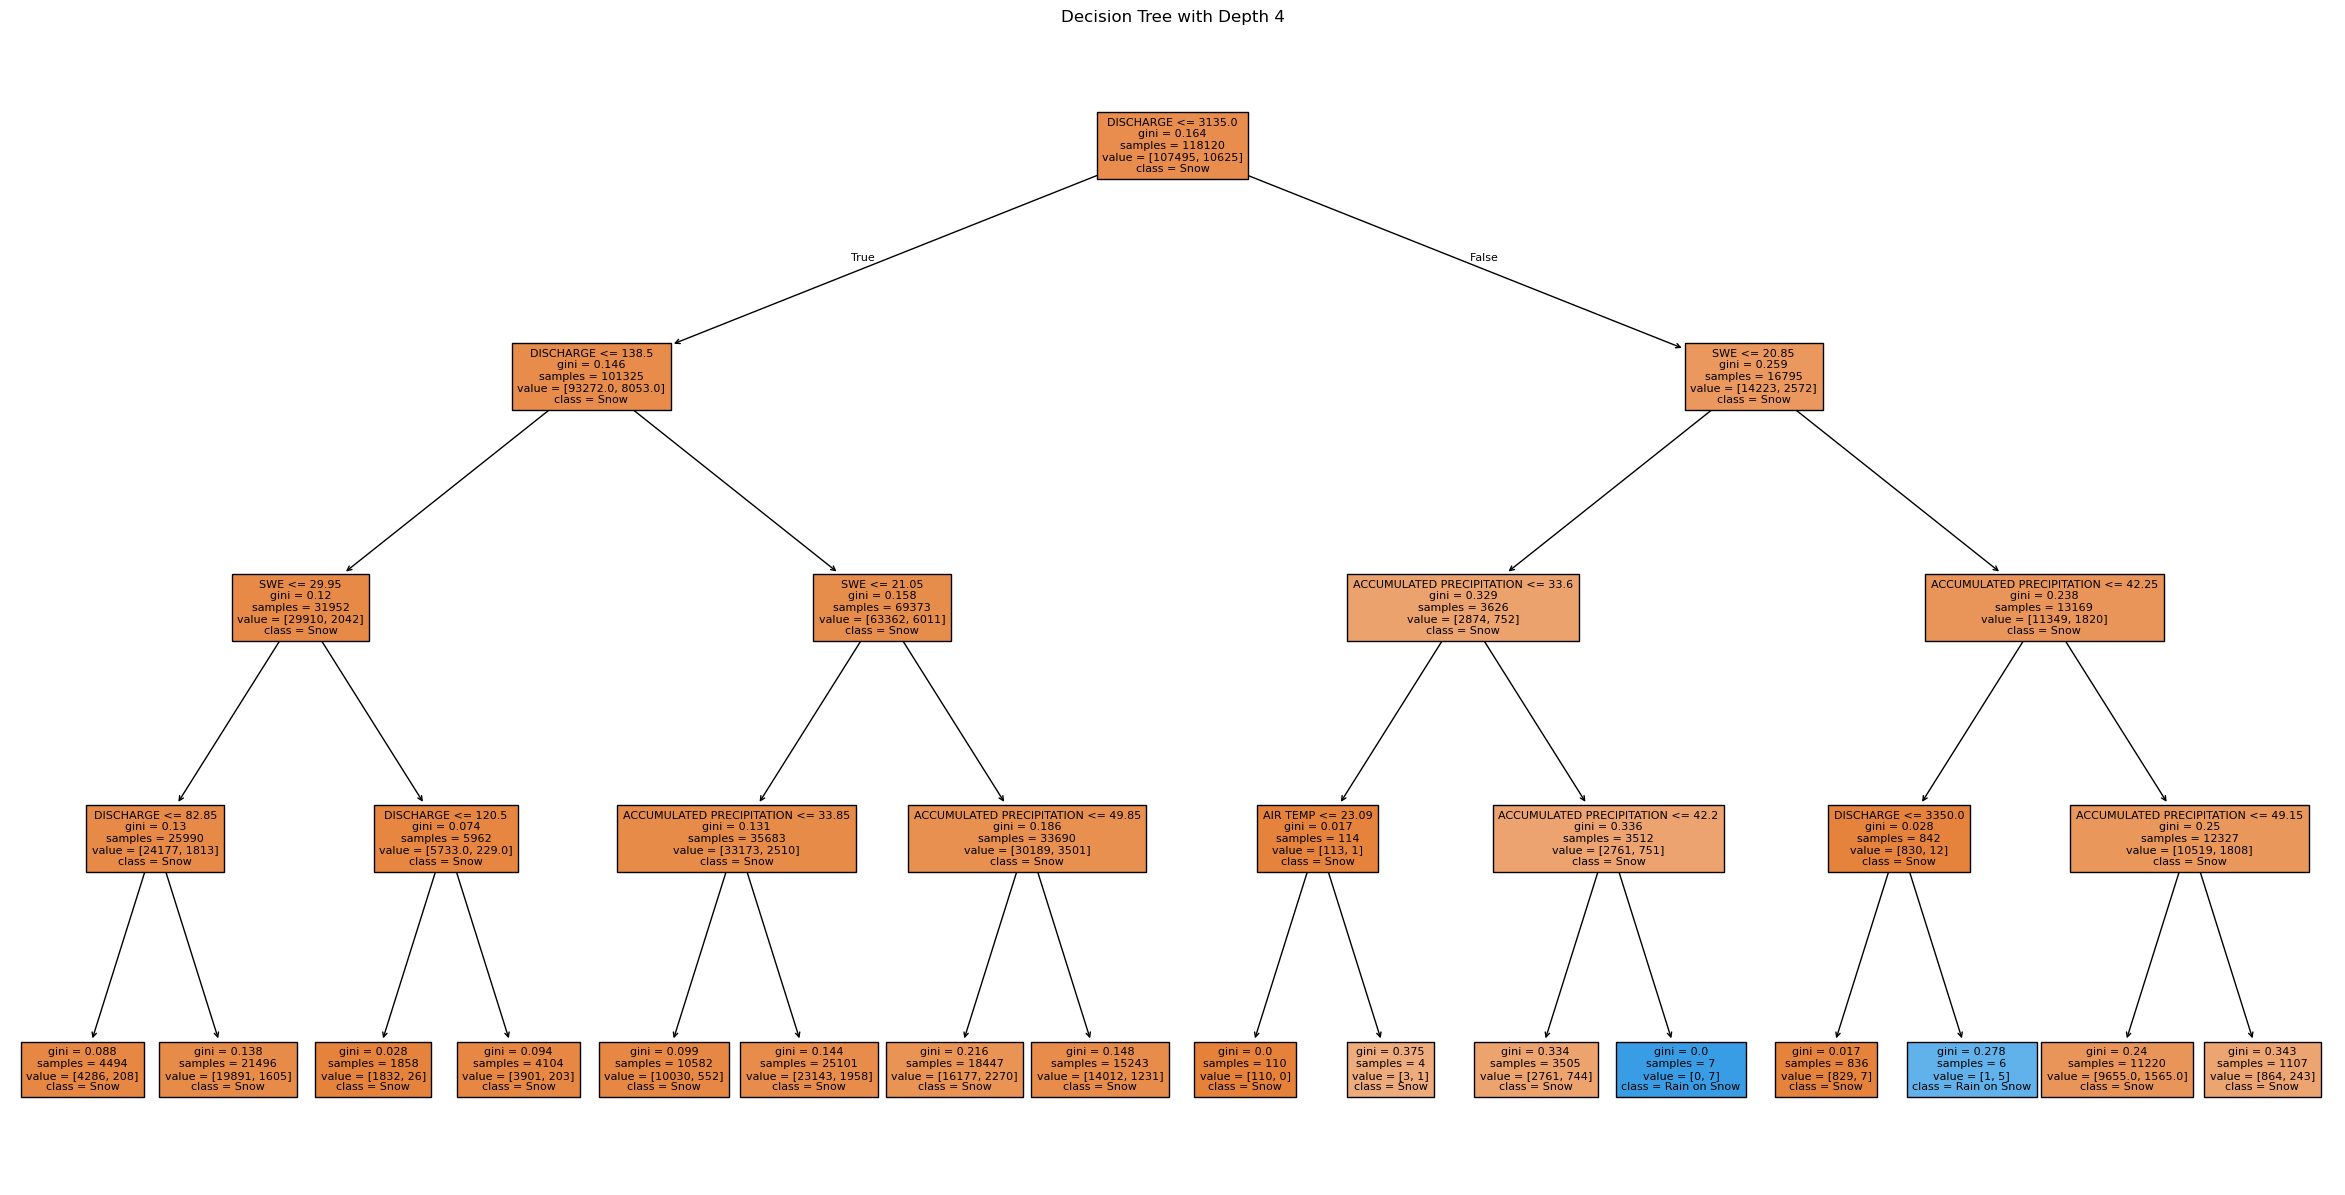

In [97]:
# Plotting with one more layer to see if we get any rain on snow boxes

clf = tree.DecisionTreeClassifier(max_depth = 4)
clf.fit(X_data_class, ground_truths.to_numpy().tolist())
plt.figure(figsize=(30, 15))
plot_tree(
    clf,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'],
    filled=True,
    #rounded=True,
    class_names=['Snow', 'Rain on Snow'],
    fontsize=8
)
plt.title("Decision Tree with Depth 4")
plt.show()